In [1]:
# Imports
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2023-07-26 18:17:21.720209: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 18:17:21.726334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-26 18:17:21.726357: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Get Coinbase Dataset
coinbase = "data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv"

coinbase_df = pd.read_csv(coinbase)

In [3]:
# Display dataframe in it's current state
coinbase_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2099755,1546898520,4006.01,4006.57,4006.00,4006.01,3.382954,13553.433078,4006.390309
2099756,1546898580,4006.01,4006.57,4006.00,4006.01,0.902164,3614.083168,4006.017232
2099757,1546898640,4006.01,4006.01,4006.00,4006.01,1.192123,4775.647308,4006.003635
2099758,1546898700,4006.01,4006.01,4005.50,4005.50,2.699700,10814.241898,4005.719991


<AxesSubplot: xlabel='Timestamp'>

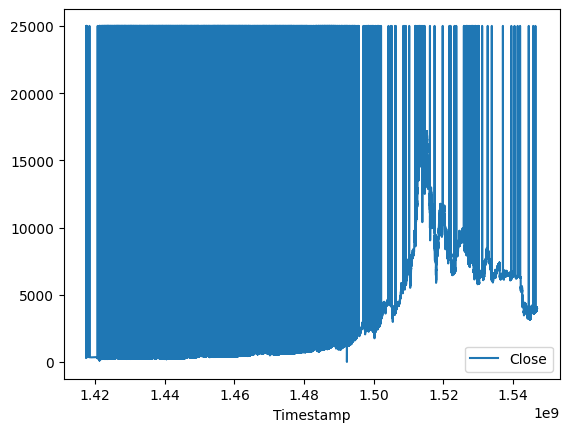

In [4]:
# Change all NaN to 25000 to see on plot and Visualize to see if there is a big
# set of data we should drop
coinbase_df.fillna(25000).plot(x='Timestamp', y='Close', kind='line')

<AxesSubplot: xlabel='Timestamp'>

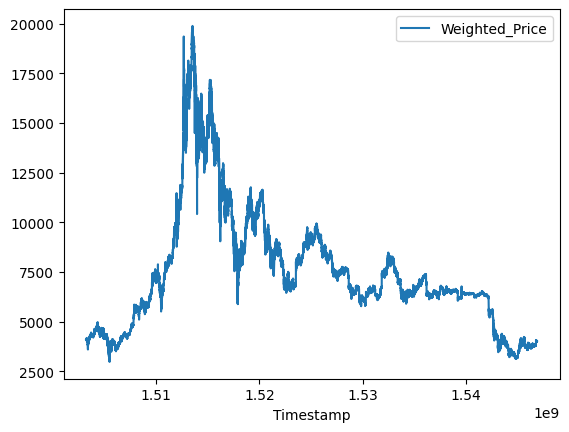

In [5]:
# Convert date string to timestamp because I(as a person) can't read timestamp
date = '2017-08-20'
element = datetime.strptime(date, "%Y-%m-%d")
timestamp = datetime.timestamp(element)

# Based on above, want to drop all rows up to August 20, 2017
coinbase_df = coinbase_df[coinbase_df['Timestamp'] >= timestamp]

# Perform Linear inrerpolation to populate values for all NaNs
coinbase_df = coinbase_df.interpolate()

coinbase_df.plot(x='Timestamp', y=['Weighted_Price'], kind='line')


In [6]:
# Save df to use throughout rest of project
# All NaN's are now removed and data is in good timeframe
df = coinbase_df[::60]

<AxesSubplot: xlabel='Timestamp'>

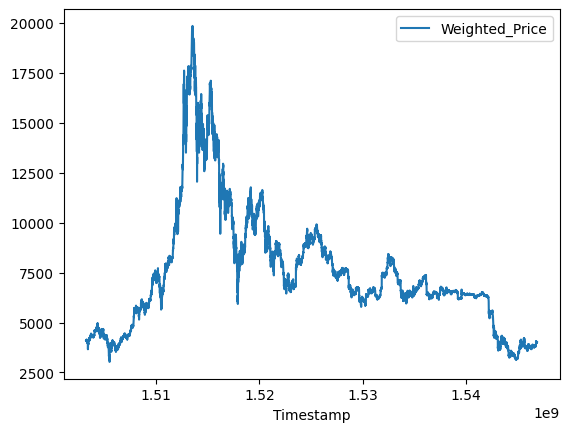

In [7]:
# Plot my hourly data
df.plot(x='Timestamp', y=['Weighted_Price'], kind='line')

## Above Here is all of my data cleaning
 - Linear fill for all NaN
 - Drop all data before a certain date because there were a lot of NaN

## Next, we are going to split the data into training/validation/test datasets
## Once data is split into sets, we will normalize
 - [Based on this paper](http://www.mirlabs.org/ijcisim/regular_papers_2014/IJCISIM_24.pdf), I tried using a tanh extimation normalization...it didn't work

 Normalization of financial data is weird...what happens in the future when
 our data is out of bounds from when we normalized...TO THE MOON!!

In [8]:
# Split the data to training/validation/test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [9]:
# Normalize the data
# Normaliziation formula from paper Zach sent
# norm = .5(tanh((0.01(data - mean))/sigma)+1)

# train_mean = train_df.mean(axis=0)
# train_sigma = train_df.std(axis=0)

# train_df = .5 * np.tanh((0.01 * (train_df - train_mean)) / train_sigma) + 1
# val_df = .5 * np.tanh((0.01 * (val_df - train_mean)) / train_sigma) + 1
# test_df = .5 * np.tanh((0.01 * (test_df - train_mean)) / train_sigma) + 1

# tanh estimation normalization didn't work, so here's typical normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
1371533,-1.731745,-1.307194,-1.306877,-1.307141,-1.306814,-0.478692,-0.443037,-1.307085
1371593,-1.731337,-1.308230,-1.307558,-1.308178,-1.307566,-0.491649,-0.447813,-1.307873
1371653,-1.730930,-1.307484,-1.307259,-1.307431,-1.307196,-0.494761,-0.448940,-1.307260
1371713,-1.730522,-1.296184,-1.296127,-1.296119,-1.296053,-0.572355,-0.477407,-1.296111
1371773,-1.730114,-1.295282,-1.295226,-1.295219,-1.295152,-0.557034,-0.471728,-1.295209
...,...,...,...,...,...,...,...,...
1880993,1.730114,-0.639583,-0.640267,-0.640503,-0.641240,-0.227866,-0.282684,-0.639622
1881053,1.730522,-0.637770,-0.634794,-0.637008,-0.634081,-0.112468,-0.217276,-0.636082
1881113,1.730930,-0.622614,-0.623317,-0.621836,-0.622595,0.407059,0.079460,-0.622575
1881173,1.731337,-0.626938,-0.627632,-0.626161,-0.626912,-0.213321,-0.273145,-0.626895


### Now that data is normalized. Let's create a 24 hour window to make each prediction

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
def plot(self, model=None, plot_col='Close', max_subplots=4):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [13]:
# Make Datasets
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [15]:
# Create a window for training
train_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1,
    label_columns=['Close']
)

In [16]:
# Build a simple LSTM Model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

2023-07-26 18:17:32.625576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-26 18:17:32.625885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-26 18:17:32.626013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BensLaptop): /proc/driver/nvidia/version does not exist
2023-07-26 18:17:32.628543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Compile and fit model
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()]
                )

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [18]:

history = compile_and_fit(lstm_model, train_window)

Epoch 1/20
265/265 [==============================] - 7s 17ms/step - loss: 0.1867 - mean_absolute_error: 0.2146 - val_loss: 0.0154 - val_mean_absolute_error: 0.0677
Epoch 2/20
265/265 [==============================] - 5s 18ms/step - loss: 0.0186 - mean_absolute_error: 0.0669 - val_loss: 0.0088 - val_mean_absolute_error: 0.0507
Epoch 3/20
265/265 [==============================] - 4s 16ms/step - loss: 0.0099 - mean_absolute_error: 0.0492 - val_loss: 0.0064 - val_mean_absolute_error: 0.0436
Epoch 4/20
265/265 [==============================] - 5s 17ms/step - loss: 0.0060 - mean_absolute_error: 0.0400 - val_loss: 0.0049 - val_mean_absolute_error: 0.0372
Epoch 5/20
265/265 [==============================] - 5s 19ms/step - loss: 0.0040 - mean_absolute_error: 0.0341 - val_loss: 0.0039 - val_mean_absolute_error: 0.0318
Epoch 6/20
265/265 [==============================] - 5s 18ms/step - loss: 0.0029 - mean_absolute_error: 0.0300 - val_loss: 0.0031 - val_mean_absolute_error: 0.0289
Epoch 7/20

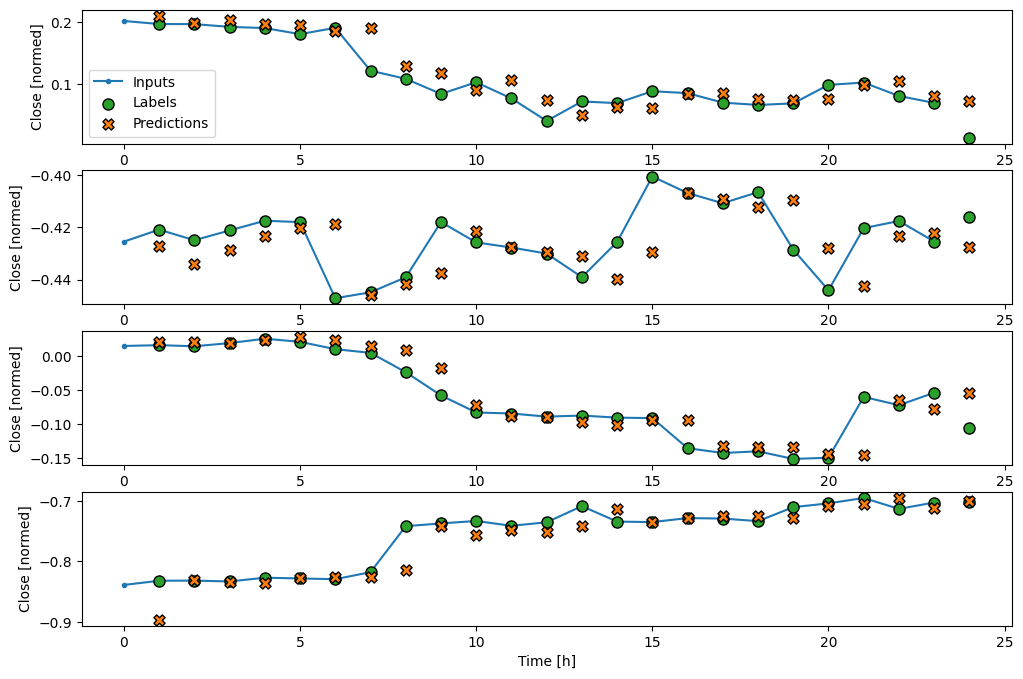

In [19]:
train_window.plot(lstm_model)